In [7]:
import numpy as np
from pandas import read_json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Reshape
from keras.layers import LSTM
from keras import Input

keras.backend.set_floatx('float64')

plt.rcParams["figure.figsize"] = (15,10)

train_datasheet = read_json('../datasets/eth-usdt-1m.json');
test_datasheet = read_json('../datasets/eth-usdt-1m-2.json');

In [8]:
def make_model(dim):
    model = Sequential()
    model.add(Input(shape=dim))
    #model.add(Reshape(target_shape=(dim, 1)))
    #model.add(Conv1D(dim, 4, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim*4, activation='sigmoid'))
    model.add(Dense(dim, activation='relu'))
    return model


In [9]:

def sma(prices, order):
    N = len(prices)
    acc = np.zeros(N)
    count = np.zeros(N)

    for tz in range(0, N):

        for tn in range(0, order):
            if tz - tn < 0: 
                continue
            
            acc[tz] += prices[tz - tn]
            count[tz] += 1

    return acc / count



In [10]:
'''
    # Delta tracker
    
    un modelo que puede reconstruir una señal a partir de sus deltas.
    
    nos indica un buen formato de datos a pasarle 
    
'''

from keras.preprocessing.sequence import TimeseriesGenerator

def track(deltas):
    res = np.zeros(len(deltas))
    acc = 1.0
    for i, delta in enumerate(deltas):
        acc *= delta
        res[i] = acc
    return res

def delta(vals):
    return np.array([ vals[idx] / vals[idx - 1] for idx in range(len(vals)) if idx > 0])

def get_tracker_model(dim=25):
    '''
        un modelo que puede reconstruir una señal a partir de sus deltas
    '''
    
    tracker_model = make_model(dim=dim-1)
    tracker_model.summary()

    tracker_model.compile(loss='mean_squared_error', optimizer='adam')
    
    train_series = np.array(train_datasheet['avg_price']).reshape(1000//dim,dim)
    deltas = [ delta(s) for s in train_series]
    tracks = [ track(s) for s in deltas]
    tracker_model.fit(tf.convert_to_tensor(deltas) * .5, 
                      tf.convert_to_tensor(tracks) * .5, 
                      epochs=6, 
                      batch_size=10)

    test_series = np.array(test_datasheet['avg_price']).reshape(1000//dim,dim)
    deltas = [ delta(s) for s in test_series]
    tracks = [ track(s) for s in deltas]

    tracker_model.fit(tf.convert_to_tensor(deltas) * .5, 
                      tf.convert_to_tensor(tracks) * .5, 
                      epochs=6, 
                      batch_size=20)
    
    results = tracker_model.evaluate(tf.convert_to_tensor(deltas), tf.convert_to_tensor(tracks),
                      batch_size=20)

    
    print("test loss, test acc:", results)
    
    return tracker_model

tracker = get_tracker_model()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 96)                2400      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2328      
Total params: 5,328
Trainable params: 5,328
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
4/4 [==============================] - 0s 804us/step - loss: 0.1274
Epoch 2/6
4/4 [==============================] - 0s 671us/step - loss: 0.1017
Epoch 3/6
4/4 [==============================] - 0s 715us/step - loss: 0.0964
Epoch 4/6
4/4 [==============================] - 0s 715us/step - loss: 0.0966
Epoch 5/6
4/4 [==============================] - 0s 552us/step - loss:

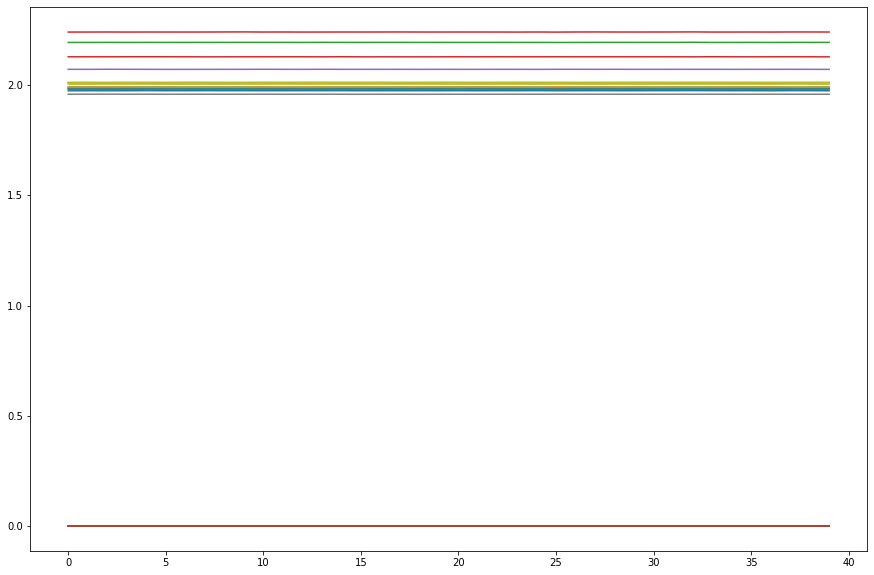

In [13]:
test_series = np.array(test_datasheet['avg_price']).reshape(1000//25,25)

#deltas = [ delta(s) for s in test_series]
paths = tracker(tf.convert_to_tensor(deltas) * .5) * 2

#plt.plot([track(delta) for delta in deltas])
plt.plot(paths * 2)





In [ ]:

train_series = np.array(train_datasheet['avg_price']).reshape(10,100)
deltas = [ delta(s) - .5 for s in train_series]
tracks = [ track(s) - .5 for s in deltas]


#plt.plot()

len(deltas[0])